In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

Boosting 方法是通过逐步聚焦于基分类器分错的样本，减小集成分类器的偏差。<br>
Bagging 方法则是采取分而治之的策略，通过对训练样本多次采样，并分别训练出多个不同模型，然后
做综合，来减小集成分类器的方差。

In [9]:
#x是特征，y是标签
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
print(x.shape)
print(y.shape)
print(np.unique(y))

(50000, 2)
(50000,)
[0 1]


(array([[ 0.71820567, -0.21809028],
        [ 0.11096372,  1.10964541],
        [ 0.61562814, -0.06539887],
        ...,
        [ 1.58004352, -0.3637176 ],
        [ 0.90929791, -0.09962261],
        [-0.97512015,  0.87195198]]),
 array([1, 0, 0, ..., 1, 0, 0]))

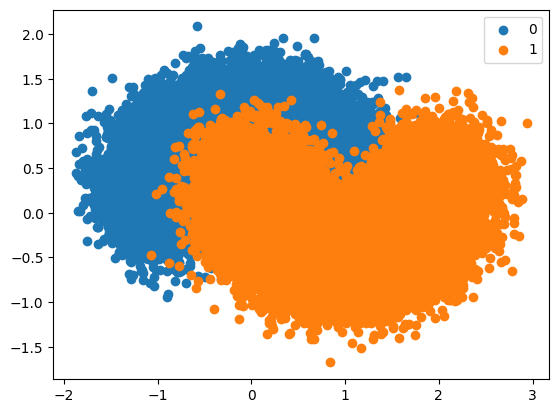

In [6]:
plt.scatter(x[y == 0, 0], x[y == 0, 1])  #拿到特征中标签为0的第0列，拿到标签为0的第一列
plt.scatter(x[y == 1, 0], x[y == 1, 1]) #拿到特征中标签为1的第0列，拿到标签为1的第一列
plt.legend(['0', '1'])
plt.show()  #图形的点颜色是自动的

In [7]:
#默认分割比例是75%和25%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression
#逻辑回归是搞分类的
log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85344

In [11]:
from sklearn.svm import SVC
svm_clf = SVC() #支持向量机
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

In [12]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier() #决策树
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87608

In [13]:
# 训练好模型，测试集做预测
y_predict1 = log_clf.predict(x_test) #逻辑回归预测
y_predict2 = svm_clf.predict(x_test) #支持向量机预测
y_predict3 = dt_clf.predict(x_test) #决策树预测

In [14]:
# bagging，纯手动bagging
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int') #投票法，大于等于2票，则为1，否则为0
y_predict[:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [15]:
from sklearn.metrics import accuracy_score
# accuracy_score计算准确率的
accuracy_score(y_test, y_predict) # 集成学习的准确率

0.90464

## 集成学习VotingClassifier(并行)

In [17]:
from sklearn.ensemble import VotingClassifier

#hard模式就是少数服从多数
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())], voting='hard') # hard模式 少数服从多数

In [18]:
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.9044

In [19]:
# hard和soft区别请看课件解释,训练时间久
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  # 支持向量机中需要加入probability
    ('dt_clf', DecisionTreeClassifier())], voting='soft') # soft模式 加权投票
voting_clf2.fit(x_train, y_train)
voting_clf2.score(x_test, y_test)

0.90432

## 集成学习BaggingClassifier(并行)

In [20]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier # 只能写一个模型

#估计器数目是5000呢？bootstrap是有放回抽样,max_samples不可以超过训练集的数目37500
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, max_samples=3000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.9128

## oob设计   

In [21]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier
# 当去做有放回的抽样时，把没有取到的样本作为验证集，可以用oob_score来评估
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=1000,
                                 bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
bagging_clf2.oob_score_  #拿没有取到的样本作为验证集

0.9156533333333333

In [22]:
bagging_clf2.score(x_test, y_test)

0.91312

## n_jobs=-1 多核并行训练

In [24]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

In [25]:
%%time # 训练时间
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)
#cpu time是实际cpu运行算法时间，wall time是墙上真实时间，就是real time（包含了进程启动时间，I/O等待时间等）

CPU times: total: 1.98 s
Wall time: 2.58 s


0.91176

In [26]:
%%time
#多核使用的时间更小, %%time要顶格来写
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True, n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 78.1 ms
Wall time: 3.49 s


0.9116

# bootstrap_features  对特征进行采样

In [27]:
#因为我们就两个特征，所以max_features设置为1,得到的分值较低是因为我们特征较少，采用随机特征不合适
#这个是只对特征进行采样
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500, max_samples=500, oob_score=True,
                                         bootstrap=True, n_jobs=-1,
                                         max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(x, y)
random_subspaces_clf.oob_score_

0.88782

In [28]:
# # 这里是为了验证总的抽样的样本数不能大于训练集的数目
# random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
#                                        n_estimators=500, max_samples=50001, oob_score=True,
#                                        bootstrap=True, n_jobs=-1,
#                                        max_features=1, bootstrap_features=True)
# random_patches_clf.fit(x, y)
# random_patches_clf.oob_score_
# #这个代码有另外一个名字就是随机森林

ValueError: max_samples must be <= n_samples

In [30]:
from sklearn.ensemble import RandomForestClassifier  #随机森林

In [31]:
%%time

rc_clf = RandomForestClassifier(n_estimators=500, random_state=666,
                                oob_score=True, n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 43.2 s
Wall time: 5.11 s


0.90268

In [32]:
%%time
rc_clf = RandomForestClassifier(max_samples=37500, n_jobs=-1) # 多核并行训练
rc_clf.fit(x_train, y_train)
rc_clf.score(x_test, y_test)

CPU times: total: 5.36 s
Wall time: 679 ms


0.904

In [33]:
%%time
#max_leaf_nodes 最大的叶子结点数
rc_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 random_state=666,
                                 oob_score=True, n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 10.6 s
Wall time: 2.77 s


0.90962

## Extra-Trees
ExtraTreesClassifier 是一种机器学习算法，属于基于决策树的集成方法家族。
它随机选择特征子集和数据样本来构建多个决策树，并将它们的预测聚合起来做出最终预测。
它可用于分类任务，并以处理嘈杂和高维数据的能力而闻名。

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90648

## Boosting(串行)

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### AdaBoost
AdaBoost是一种迭代算法，它通过改变训练样本的权重，来提升基分类器的权重，使得分类器更加准确。

In [37]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)


CPU times: total: 109 ms
Wall time: 140 ms


0.87568

### GradientBoosting
GradientBoosting是一种基于决策树的集成学习方法，它通过迭代的方式，逐步提升基分类器的权重，
使得分类器更加准确。

In [38]:
#它默认用的也是决策树，增加了基分类器的数目后，准确率提升
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=500)
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

0.91232